In [1]:
# if you are havign difficulty downloading numpy or scipy (requirements for sklearn), 
# https://scikit-learn.org/stable/modules/tree.html
from sklearn import tree, metrics
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# load data cleaned from rscript
sc_df = pd.read_csv('../data/sc_decisions_final.csv')

# drop first col of indexes
sc_df = sc_df.iloc[: , 1:]

# fill missing values as they are legitimate
sc_df = sc_df.fillna("N/A")

sc_df.head()

,c_lcDisagreement,c_lcDispositionDirection,c_issueArea,c_adminActionBool,c_oralArgBool,c_reargBool,c_decisionTime,c_formerCourt,c_caseOriginRegion,c_caseOriginCourt,...,e_JCApproval,j_justiceGender,j_justiceDecisionAgeBand,j_justiceRegion,j_justiceReligion,j_justiceEthnicity,j_justicePresidentParty,j_justiceVotesAppointed,direction,yearDecision
0,0.0,Conservative,Judicial Power,1,1,0,31-180 Days,0,South,District Court,...,Approve,Male,65+,Midwest,Protestant,Caucasian,Republican,<75%,Liberal,2000
1,0.0,Conservative,Judicial Power,1,1,0,31-180 Days,1,South,District Court,...,Approve,Male,65+,Midwest,Protestant,Caucasian,Republican,>=75%,Liberal,2000
2,0.0,Conservative,Judicial Power,1,1,0,31-180 Days,0,South,District Court,...,Approve,Female,65+,West,Protestant,Caucasian,Republican,>=75%,Liberal,2000
3,0.0,Conservative,Judicial Power,1,1,0,31-180 Days,1,South,District Court,...,Approve,Male,0-65,Northeast,Catholicism,Caucasian,Republican,>=75%,Conservative,2000
4,0.0,Conservative,Judicial Power,1,1,0,31-180 Days,1,South,District Court,...,Approve,Male,0-65,West,Catholicism,Caucasian,Republican,>=75%,Liberal,2000


# Prepping features for modeling

In [2]:
# select explanatory and response variables
X = sc_df.loc[:, sc_df.columns != 'direction']
y = sc_df[['direction']].astype("category")

# encode target
y = y.apply(lambda x: x.cat.codes)

# check target encoding
# y.apply(lambda x: x.cat.categories) 

# treat booleans and multiple categories differently
cat_vars = list(X.columns[X.nunique() > 2])
bool_vars = list(X.columns[X.nunique() == 2])

# encode categorical features
X_cat = pd.get_dummies(X[cat_vars], columns = cat_vars)
X_bool = pd.get_dummies(X[bool_vars], columns = bool_vars, drop_first = True)
X = pd.concat([X_cat, X_bool], axis = 1)

# split into training and testing
X_train, X_test, y_train, y_test = train_test_split(X , y, test_size = 0.25, random_state = 42)
print("Training split input- ", X_train.shape)
print("Testing split input- ", X_test.shape)

Training split input-  (10535, 74)
Testing split input-  (3512, 74)


# Tune Decision Tree

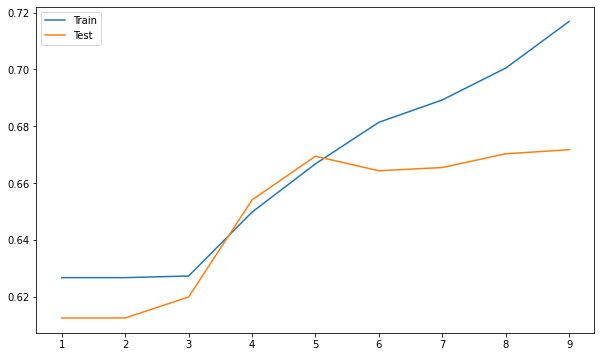

In [3]:
# test for overfitting/underfitting
train_scores = []
test_scores = []

# tree depth
depths = [i for i in range(1, 10)]

# evaluate decision tree for each depth
for i in depths:
    model = DecisionTreeClassifier(max_depth=i, random_state = 42)
    model.fit(X_train, y_train)
    # evaluate train dataset
    yhat_train = model.predict(X_train)
    train_accuracy = metrics.accuracy_score(y_train, yhat_train)
    train_scores.append(train_accuracy)
    
    # evaluate test dataset
    yhat_test = model.predict(X_test)
    test_accuracy = metrics.accuracy_score(y_test, yhat_test)
    test_scores.append(test_accuracy)

# plot training and test results
plt.figure(figsize=(10,6)) 
plt.plot(depths, train_scores, label='Train')
plt.plot(depths, test_scores, label='Test')
plt.legend()
plt.savefig('../output/max_depth_dt.png')
# depth of around 5

In [4]:
# create tree object
tree = DecisionTreeClassifier(max_depth=5, random_state = 42) # test depth

# train tree
model = tree.fit(X_train, y_train)

# predict test target
y_pred = model.predict(X_test)

# accuracy
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6694191343963554


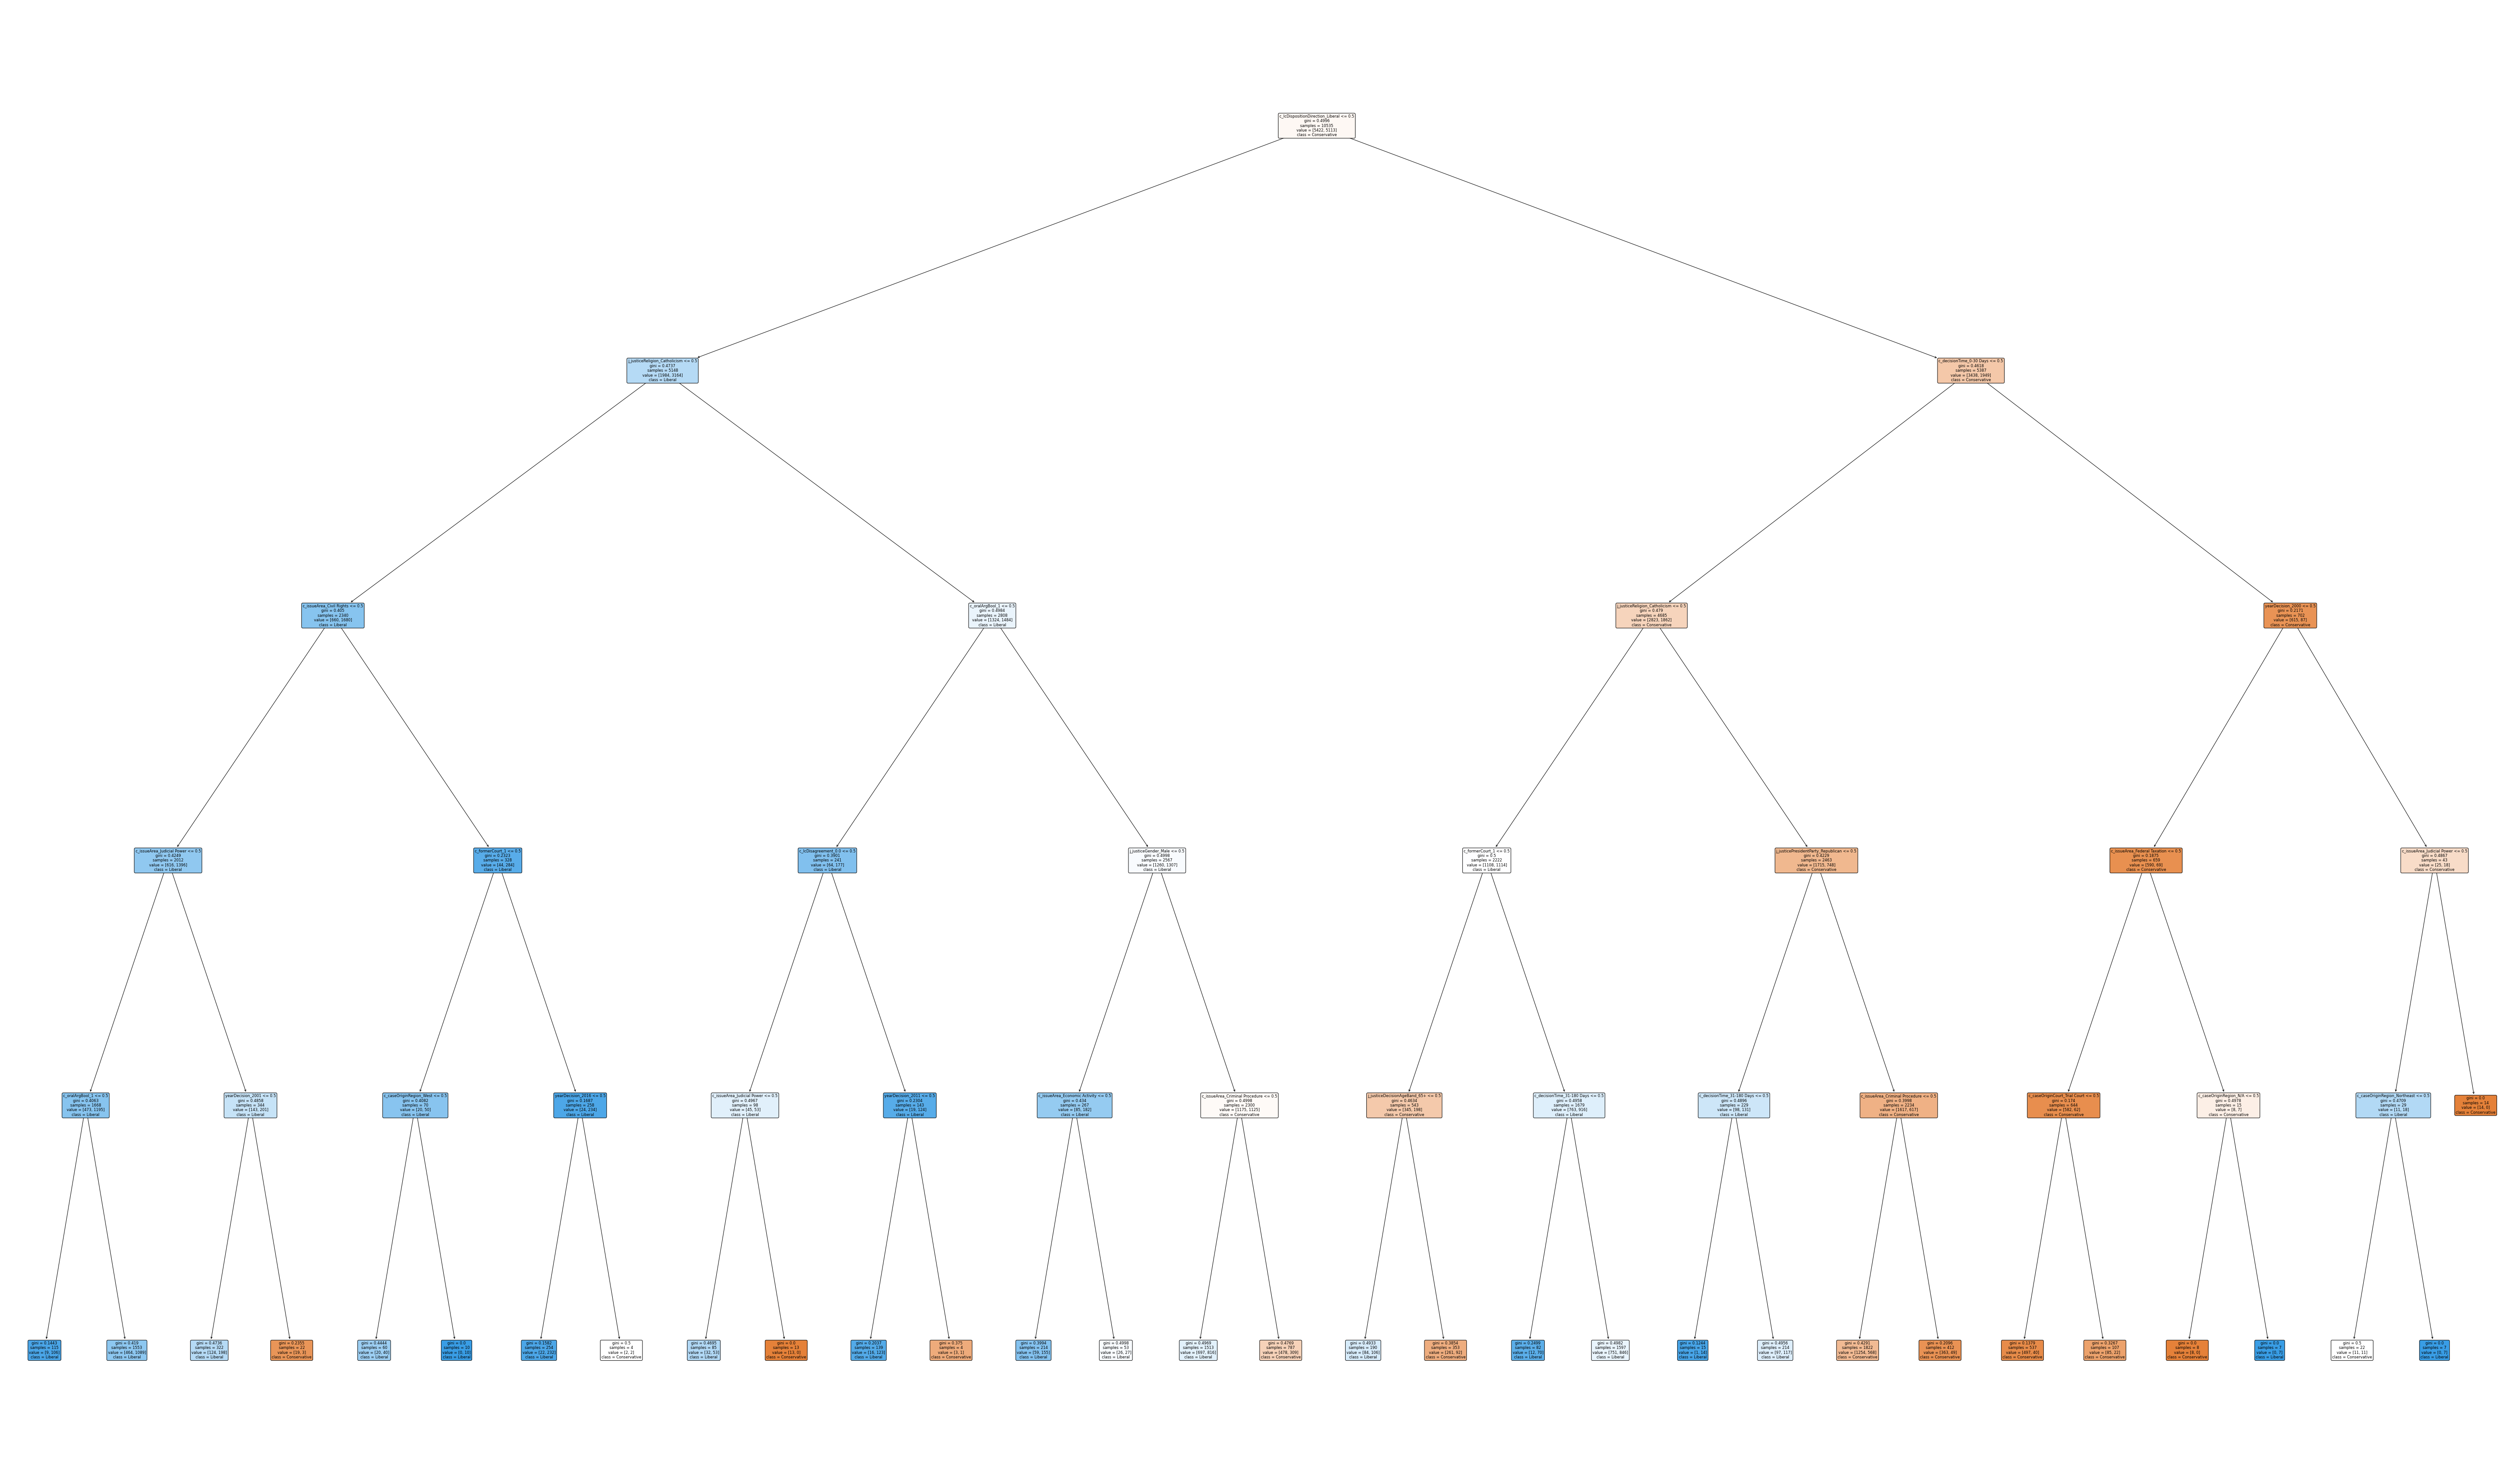

In [5]:
plt.figure(figsize=(100,60)) 
plot_tree(decision_tree=model, feature_names = X.columns, 
                      class_names =["Conservative", "Liberal"] , filled = True , precision = 4, rounded = True)
plt.savefig('../output/dt.png')

# Feature importance

In [6]:
# Feature importances
importances = model.feature_importances_

pd.DataFrame(data = {
    'feature': X.columns,
    'importance': importances
}).sort_values("importance", ascending = False).head(10)

,feature,importance
4,c_lcDispositionDirection_Liberal,0.366471
38,j_justiceReligion_Catholicism,0.199199
19,c_decisionTime_0-30 Days,0.099480
8,c_issueArea_Criminal Procedure,0.051477
72,j_justicePresidentParty_Republican,0.039604
62,c_oralArgBool_1,0.035697
64,c_formerCourt_1,0.033707
14,c_issueArea_Judicial Power,0.028316
70,j_justiceDecisionAgeBand_65+,0.023776
21,c_decisionTime_31-180 Days,0.022388
